In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import sys
import os
import random
import gc
import subprocess
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
plt.style.use('./stylelib/custom.mplstyle')

%reload_ext autoreload
%autoreload 2
import preprocessing
import plotter

---

## 1 Data inspection and loading
### 1.1 Downsample training data
Only 0.5% of the all training records is used for exploratory data analysis

In [4]:
%%time

dir_data = './data'
from_scratch = False

csv_train_raw = os.path.join(dir_data, 'train.csv')
csv_train = os.path.join(dir_data, 'train_sample.csv')
if from_scratch:
    nlines_raw, nlines_reduced = preprocessing.csv_randomized_downsamp(
        csv_in=csv_train_raw, csv_out=csv_train, fraction=0.005
    )

CPU times: user 14 µs, sys: 0 ns, total: 14 µs
Wall time: 16.9 µs


### 1.2 Load data into dataframe
#### (1) Field inspections
For efficiency concerns, we use shell commands instead of pandas operations.

In [5]:
# Quick check of training data fields by calling system shell command
!head -2 ./data/train_sample.csv

ip,app,device,os,channel,click_time,attributed_time,is_attributed
106284,15,1,41,277,2017-11-06 22:57:46,,0


In [6]:
# Quick check of test data fields by calling system shell command
!head -2 ./data/test.csv

click_id,ip,app,device,os,channel,click_time
0,5744,9,1,3,107,2017-11-10 04:00:00


**[CAUTION]** We should be very careful about the use of datetime feature `click_time`. The simple check above indicates the date value of the training and testing data don't overlap. For this reason, we should NOT use date or day-of-the-week as a feature when training our model.

**[Notes] Field selections** <br>
Note that from above that training and testing data don't share the same fields. <br>
To prepare data for subsequent processing, we only preserve fields that are common in both training and testing data. One exception is the `is_attributed` field in training data; It is the prediction target and thus needs to be preserved.

In [24]:
# Extract field names from training and testing data
fields_train = preprocessing.csv_list_fields(csv_in=csv_train)
csv_test = os.path.join(dir_data, 'test.csv')
fields_test = preprocessing.csv_list_fields(csv_in=csv_test)

# Extract fields shared by both training and testing data
fields_use = list(set(fields_train) & (set(fields_test)))
print('Data fields shared by both training and testing data:\n', fields_use)

Data fields shared by both training and testing data:
 ['channel', 'device', 'os', 'click_time', 'app', 'ip']


#### (2) Load into dataframe

In [120]:
# Load randomly sampled data subset into pandas dataframe,
# and sort by click time (and reset index)
df = pd.read_csv(
    csv_train, usecols=fields_use + ['is_attributed'],
    parse_dates=['click_time']
).sort_values(by='click_time').reset_index(drop=True)

# Convert click time from UTC to local time
df['click_time'] = (
    pd.DatetimeIndex(df['click_time']).tz_localize('utc')
    .tz_convert('Asia/Shanghai')
)

In [121]:
# Inspect first few lines
df.head(3)

,ip,app,device,os,channel,click_time,is_attributed
0,86946,3,1,19,379,2017-11-06 23:46:14+08:00,0
1,119349,3,1,17,379,2017-11-06 23:57:47+08:00,0
2,73516,18,1,22,107,2017-11-07 00:00:00+08:00,0


---
## 2. Exploratory data analysis
### 2.1 Do we have imbalanced classes?

In [122]:
# Inspect data size
nclick_total =len(df)
percentage_pos = (df['is_attributed'].sum()) / nclick_total * 100
print('Percentage of positive target = {:.3f}%'.format(percentage_pos))

Percentage of positive target = 0.251%


**[CAUTION] Class imbalance**<br>
Given that only 0.25% of the records has positive target values (`df['is_attributed'] == 1`), we have **an extreme case of class imbalance** at hand.

### 2.2 Convert datetime variable to more usable form
As mentioned a few cells earlier, the training data and out-of-sample testing data don't cover the same time window in terms of day-of-the-week. To convert raw `click_time` into a more usable form, we take the following steps:

* Extract hour-of-the-day and use it as a separate feature `click_hour`
* Compute elapsed time (in total number of seconds) relative to "2017-11-01 00:00:00" (this is an arbitrary choice only to ensure positive values) and set it up as another feature `click_etime_sec`; the resulting value will be engineered further through *discretization*

In [123]:
# Extract hour of the day
df['click_hour'] = df['click_time'].dt.hour

# Compute elapsed time (in seconds) relative to 2017-11-01 local time
df['click_etime_sec'] = (
    df['click_time'] - pd.Timestamp('2017-11-01', tz='Asia/Shanghai')
).dt.total_seconds()

# Drop raw `click_time`
df.drop(columns=['click_time'], inplace=True)

In [124]:
df.head()

,ip,app,device,os,channel,is_attributed,click_hour,click_etime_sec
0,86946,3,1,19,379,0,23,517574.0
1,119349,3,1,17,379,0,23,518267.0
2,73516,18,1,22,107,0,0,518400.0
3,101941,12,1,9,259,0,0,518400.0
4,209129,3,1,13,452,0,0,518400.0


### 2.3 Train-test split, and set aside testing data

In [189]:
# Split the original dataframe into in-sample training and testing sets
# Because stratified sampling is the default option of sklearn, it is not
# explicitly set
df_train, df_test = train_test_split(df, test_size=0.3, random_state=42)

# Double check class ratios after train-test split
print('Training data (pos%):', 100 * df_train['is_attributed'].sum() / len(df_train))
print('Testing data (pos%):', 100 * df_test['is_attributed'].sum() / len(df_test))

Training data (pos%): 0.24939621084641736
Testing data (pos%): 0.25346486104501076


### 2.4 Inspect variable distributions of training data

In [125]:
# Count the amount of unique values
df_counts = pd.DataFrame()
df_counts['n_unique'] = df_train.nunique()
df_counts['n_unique (%)'] = 100 * df_counts['n_unique'] / len(df_train)
df_counts.T

,ip,app,device,os,channel,is_attributed,click_hour,click_etime_sec
n_unique,71528.000000,264.000000,338.000000,182.000000,168.000000,2.000000,24.000000,217116.00000
n_unique (%),11.052548,0.040793,0.052228,0.028123,0.025959,0.000309,0.003708,33.54889


**[TAKE AWAY]**<br>
* Without exception, the total number of unique values for each of these variables is markedly smaller than the total number of clicks. This indicates that many-to-one mapping is typical between clicks and these variables. This makes sense because a single user can generate multiple clicks.
* The amount of distinct values in categorical features is very high. We will need to make major efforts in feature engineering.

### 2.5 Handle rare labels 

In [212]:
mask = (
    df_train['app'].value_counts() / len(df_train) / 0.0025 < 0.0001
)
df_train['app_rare'] = df_train.app.map(mask.to_dict())
df_train[df_train.is_attributed == 1].app_rare.value_counts()

/Users/shandou/anaconda3/envs/mlnd_capstone/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


False    1614
Name: app_rare, dtype: int64

In [217]:
mask = (
    df_test['app'].value_counts() / len(df_test) / 0.0025 < 0.0001
)
df_test['app_rare'] = df_test.app.map(mask.to_dict())
df_test[df_test.is_attributed == 1].app_rare.value_counts()

/Users/shandou/anaconda3/envs/mlnd_capstone/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


False    703
Name: app_rare, dtype: int64

In [179]:
prob_df = pd.DataFrame(df_train.groupby(['app'])['is_attributed'].mean())
prob_df['not_attributed'] = 1 - prob_df['is_attributed']
prob_df.head()

,is_attributed,not_attributed
app,,
0,0.411765,0.588235
1,0.000198,0.999802
2,0.000198,0.999802
3,0.000228,0.999772
4,0.000000,1.000000


In [180]:
prob_df.loc[prob_df.is_attributed == 0, 'is_attributed'] = 1e-5
prob_df.head()

,is_attributed,not_attributed
app,,
0,0.411765,0.588235
1,0.000198,0.999802
2,0.000198,0.999802
3,0.000228,0.999772
4,0.000010,1.000000


In [181]:
prob_df['WoE'] = np.log(prob_df.is_attributed / prob_df.not_attributed)
prob_df.head()

,is_attributed,not_attributed,WoE
app,,,
0,0.411765,0.588235,-0.356675
1,0.000198,0.999802,-8.528380
2,0.000198,0.999802,-8.527737
3,0.000228,0.999772,-8.387464
4,0.000010,1.000000,-11.512925


In [182]:
app_mapper = prob_df['WoE'].to_dict()
df_train['app_ordered'] = df_train.app.map(app_mapper)
df_test['app_ordered'] = df_test.app.map(app_mapper)

In [186]:
df_train.isnull().sum()

ip                 0
app                0
device             0
os                 0
channel            0
is_attributed      0
click_hour         0
click_etime_sec    0
app_ordered        0
dtype: int64

In [185]:
df_test.isnull().sum()

ip                  0
app                 0
device              0
os                  0
channel             0
is_attributed       0
click_hour          0
click_etime_sec     0
app_ordered        17
dtype: int64

In [163]:
np.diff(np.sort(df_train['device'].unique()))

array([  1,   1,   2,   1,   1,   1,   1,   1,   2,   3,   2,   1,   1,
         1,   1,   1,   3,   1,   1,   3,   1,   3,   1,   2,   1,   1,
         2,   2,   2,   1,   1,   1,   2,   1,   1,   1,   1,   1,   2,
         2,   1,   1,   1,   2,   1,   3,   1,   2,   1,   1,   1,   1,
         2,   2,   1,   3,   6,   1,   3,   2,   1,   1,   1,   3,   1,
         1,   1,   1,   2,   3,   1,   2,   2,   2,   2,   6,   3,   2,
         2,   1,   3,   1,   1,   1,   3,   4,   2,   6,   1,   1,   2,
         3,   1,   6,   2,   1,   1,   2,   4,   3,   1,   1,   1,   4,
         1,   1,   1,   9,   3,   1,   2,   1,   3,   1,   1,   1,   2,
         3,   1,   1,   1,  10,   1,   3,   2,   3,   1,   1,  10,   9,
         2,   1,   1,   4,   1,   1,   1,   3,   1,   1,   4,  10,   1,
         1,   5,   2,   2,   4,   4,   1,   2,   7,   1,   1,   1,   7,
         5,   3,   1,   4,   1,   1,   4,   2,   1,   5,   5,   1,   3,
         2,   5,   2,   5,   2,   1,   2,   1,   1,   1,   2,   

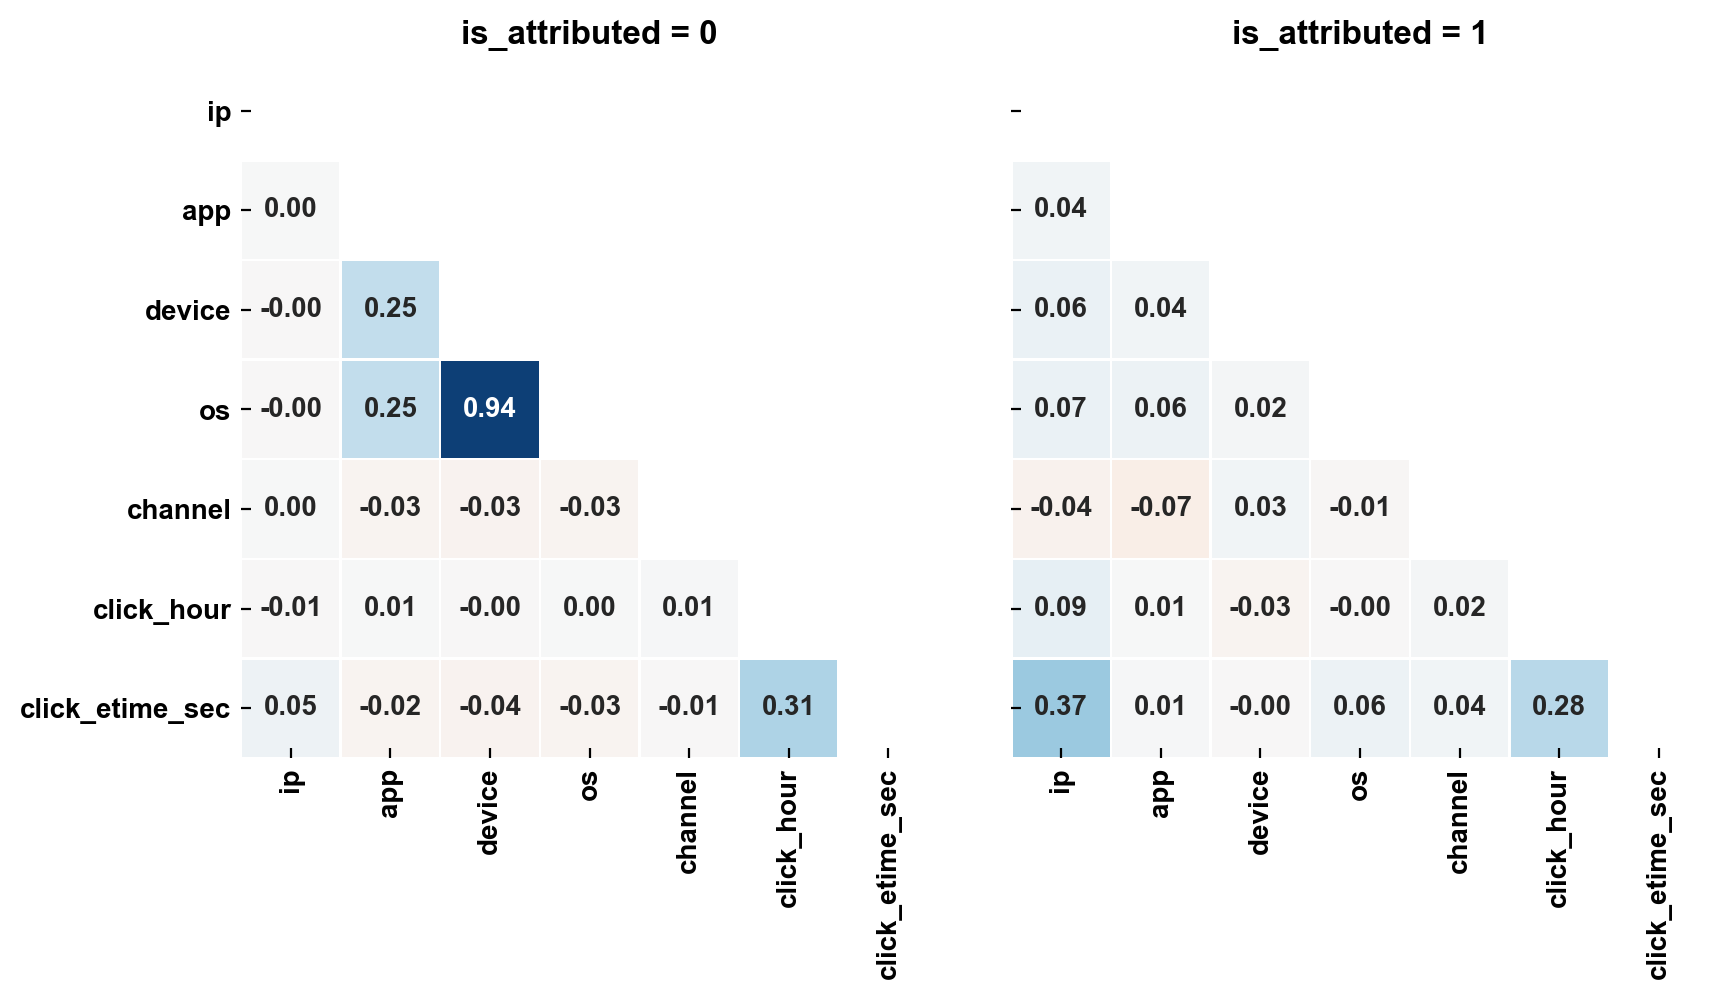

In [151]:
# Exclude target variable from correlation calculation
cols_corr = [x for x in df_train.columns if x != 'is_attributed']

# Plot positive and negative cases in separate heatmaps
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(8, 4))
fig.tight_layout()
for i, axi in enumerate(ax):
    corr_matrix = df_train[df_train['is_attributed'] == i][cols_corr].corr()
    mask = np.zeros_like(corr_matrix, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(
        corr_matrix, mask=mask, cmap='RdBu', vmin=-1, vmax=1,
        square=True, linewidths=.5, annot=True, fmt='.2f',ax=axi, cbar=False
    )
    axi.set(title='is_attributed = {}'.format(i))
plt.show();

**[TAKE AWAY]**<br>
This is interesting--in our negative cases (`is_attributed == 0`), a strong linear correlation exists between `os` and `device`. This makes 

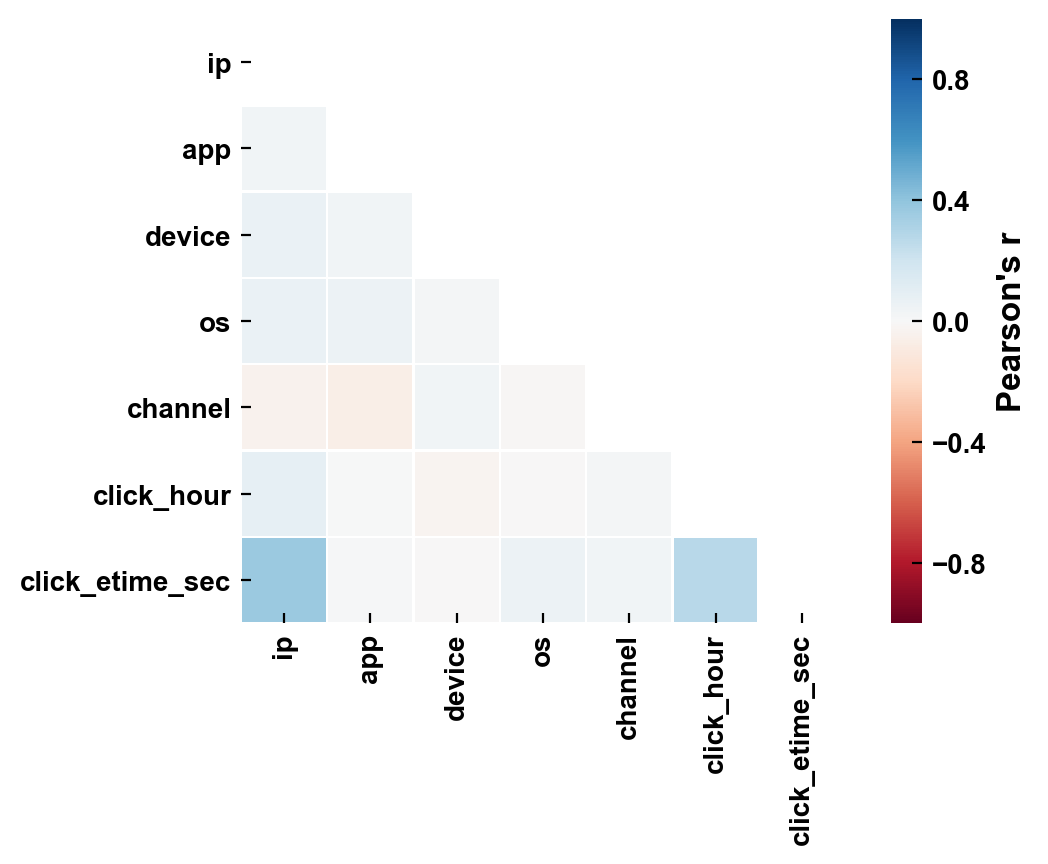

In [133]:
cols_corr = [x for x in df_train.columns if x != 'is_attributed']
corr_matrix = df_train[df_train['is_attributed'] == 1][cols_corr].corr()
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(
    corr_matrix, mask=mask, cmap='RdBu', vmin=-1, vmax=1,
    square=True, linewidths=.5,
    cbar_kws={'label':'Pearson\'s r'}
);

In [18]:
df_unique = pd.DataFrame()
df_unique['n_unique'] = df.nunique()
df_unique['n_unique_percent'] = 100 * (df.nunique() / len(df))
df_unique

,n_unique,n_unique_percent
ip,79498,8.598850
app,281,0.030394
device,412,0.044564
os,192,0.020768
channel,169,0.018280
click_time,231735,25.065466
is_attributed,2,0.000216
click_hour,24,0.002596
click_day,5,0.000541


In [15]:
len(set(df[df.is_attributed == 1]['app']) & set(df[df.is_attributed == 0]['app']))

81

### 1.3 Time feature construction
* Convert UTC time to Asia/Shanghai time
* Extract hour of the day from `click_time` as a separate feature `click_hour` 

In [ ]:
# Extract hour of the day
df_train['click_hour'] = df_train['click_time'].dt.hour
df_train.drop(columns=['click_time'], inplace=True)

In [ ]:
df_train.head()

In [ ]:
cols_corr = [x for x in df_train.columns if x != 'is_attributed']
corr_matrix = df_train[cols_corr].corr()
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(
    corr_matrix, mask=mask, cmap='RdBu', vmin=-1, vmax=1,
    square=True, linewidths=.5,
    cbar_kws={'label':'Pearson\'s r'}
);

In [ ]:
df_train.drop(columns=['os'], inplace=True)
df_train.head()

### 1.4 Feature engineering
Construct feature combinations, and use the counts of records belonging to each of the combinations as the new features.

In [ ]:
# Generate feature combinations
feature_primary = 'ip'
feature_other = ['device', 'channel', 'app']
feature_combinations = preprocessing.list_feature_combinations(
    feature_primary=feature_primary, feature_other=feature_other
)
print(feature_combinations)

In [ ]:
csv_engineered = os.path.join(dir_data, 'train_sample_engineered.csv')
if not os.path.exists(csv_engineered):
    df_engineered = preprocessing.df_engineered(
        df_in=df_train, feature_combinations=feature_combinations
    )
else:
    df_engineered = pd.read_csv(csv_engineered)
display(df_engineered.head(3))

---
## 2. Exploratory data analysis

(1) Train-test split

In [ ]:
df_train, df_test = train_test_split(df_engineered, test_size=0.2, random_state=42)

In [ ]:
df_train.head()

(2) Visualize click count as function of click time

In [ ]:
hist_params = dict(bins=24, edgecolor='w', alpha=0.5)
fig, ax = plt.subplots()
ax = plotter.compare_hist(df_train, by='click_hour', hist_params=hist_params, ax=ax)
ax.set(xlabel='Click time in hour-of-the day (Shanghai time)')
plt.show();

---
## 3. Machine learning

In [ ]:
#cols = [x for x in df_train.columns if 'count' in x or 'mean' in x]
cols = [x for x in df_train.columns if 'is_attributed' not in x]
X_train, y_train = (df_train[cols], df_train['is_attributed'])
X_test, y_test = (df_test[cols], df_test['is_attributed'])

In [ ]:
cols

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import (StandardScaler, MinMaxScaler)
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import (cross_val_score, RandomizedSearchCV)

In [ ]:
model = DecisionTreeClassifier(class_weight='balanced')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
auc = roc_auc_score(y_test, y_pred)
print(auc)

In [ ]:
model = RandomForestClassifier(class_weight='balanced', n_estimators=10, max_depth=8)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
auc = roc_auc_score(y_test, y_pred)
print(auc)

In [ ]:
import xgboost as xgb
train_matrix = xgb.DMatrix(data=X_train, label=y_train)
test_matrix = xgb.DMatrix(data=X_test, label=y_test)
params = dict(objective='binary:logistic', 'max_depth'=8)



model = xgb.XGBClassifier(objective='binary:logistic', n_estimators=, seed=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
auc = roc_auc_score(y_test, y_pred)
print(auc)

In [ ]:
from sklearn.feature_selection import RFE
estimator = DecisionTreeClassifier()
selector = RFE(estimator, step=1)
selector = selector.fit(X_train, y_train)

In [ ]:
print(selector.support_)
print(selector.ranking_)

In [ ]:
col_array = np.array(cols)
col_array

In [ ]:
cols = col_array[selector.support_]

In [ ]:
X_train, y_train = (df_train[cols], df_train['is_attributed'])
X_test, y_test = (df_test[cols], df_test['is_attributed'])

In [ ]:
model = DecisionTreeClassifier()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
auc = roc_auc_score(y_test, y_pred)
print(auc)

X_train.shape